In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature

In [3]:
model = model.drop_processes(['environment', 'phenology', 'appearance', 'growth', 'geometry'])

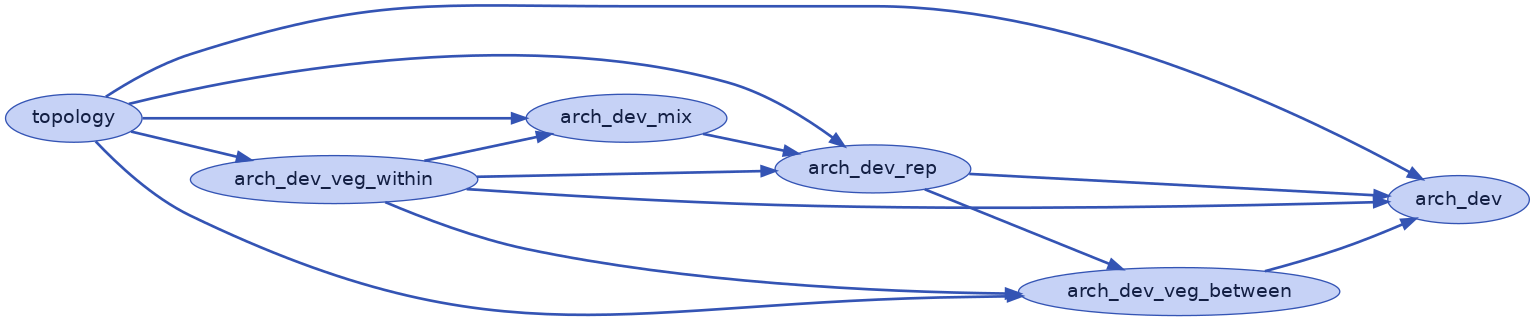

In [4]:
model.visualize()

In [5]:
nb_gus = 3
g = ig.Graph.Tree(nb_gus, 2, mode=ig.TREE_OUT)
adjacency = np.array(g.get_adjacency().data)

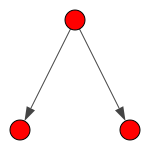

In [6]:
ig.plot(g, bbox=(0,0,150,150), layout=g.layout_reingold_tilford())

In [7]:
ds = vmlab.create_setup(
    model=model,
    setup_toml='../share/setup/vmango.toml',
    clocks={
        'day': pd.date_range(start='2002-04-01', end='2005-12-31', freq="1d")
    },
    main_clock='day',
    input_vars={
        'topology': {
            'seed': 2,
            'current_cycle': 3,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214,
            'adjacency': adjacency,
            'is_apical': np.array([1.] + ([0.] * (nb_gus - 2)) + [1.]),
            'ancestor_is_apical': np.ones(nb_gus),
            'ancestor_nature': np.full(nb_gus, Nature.VEGETATIVE),
            'appearance_month': np.array([3] + ([4] * (nb_gus - 1))),
            'appearance_date': np.array(['2002-03-01'] + (['2002-04-01'] * (nb_gus - 1))),
            'cycle': np.full(nb_gus, 2),
        },
        'arch_dev': {
            'pot_burst_date': np.full(nb_gus, np.datetime64('NAT'), dtype='datetime64[D]'),
            'pot_flowering_date': np.full(nb_gus, np.datetime64('NAT'), dtype='datetime64[D]'),
            'pot_has_apical_child': np.zeros(nb_gus),
            'pot_nb_lateral_children': np.zeros(nb_gus),
            'pot_nature': np.zeros(nb_gus),
            'pot_nb_inflo': np.zeros(nb_gus),
            'pot_nb_fruit': np.zeros(nb_gus)
        },
    },
    output_vars=None
)

In [8]:
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar()])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                             (GU: 50, day: 1371)
Coordinates:
  * GU                                                  (GU) <U10 'GU0' ... '...
  * day                                                 (day) datetime64[ns] ...
Data variables: (12/51)
    arch_dev__pot_burst_date                            (GU) datetime64[D] Na...
    arch_dev__pot_flowering_date                        (GU) datetime64[D] Na...
    arch_dev__pot_has_apical_child                      (GU) float64 0.0 ... 0.0
    arch_dev__pot_nature                                (GU) float64 0.0 ... 0.0
    arch_dev__pot_nb_fruit                              (GU) float64 0.0 ... 0.0
    arch_dev__pot_nb_inflo                              (GU) float64 0.0 ... 0.0
    ...                                                  ...
    topology__month_begin_veg_cycle                     int64 7
    topology__nb_descendants                            (GU) int64 48 6 ... 0 0
    topology__nb_fruit                                  (GU) float32 0.0 ... 0.0
    topology__nb_inflo                                  (GU) float32 0.0 ... 0.0
    topology__parent_is_apical                          (GU) float64 1.0 ... 0.0
    topology__seed                                      int64 2

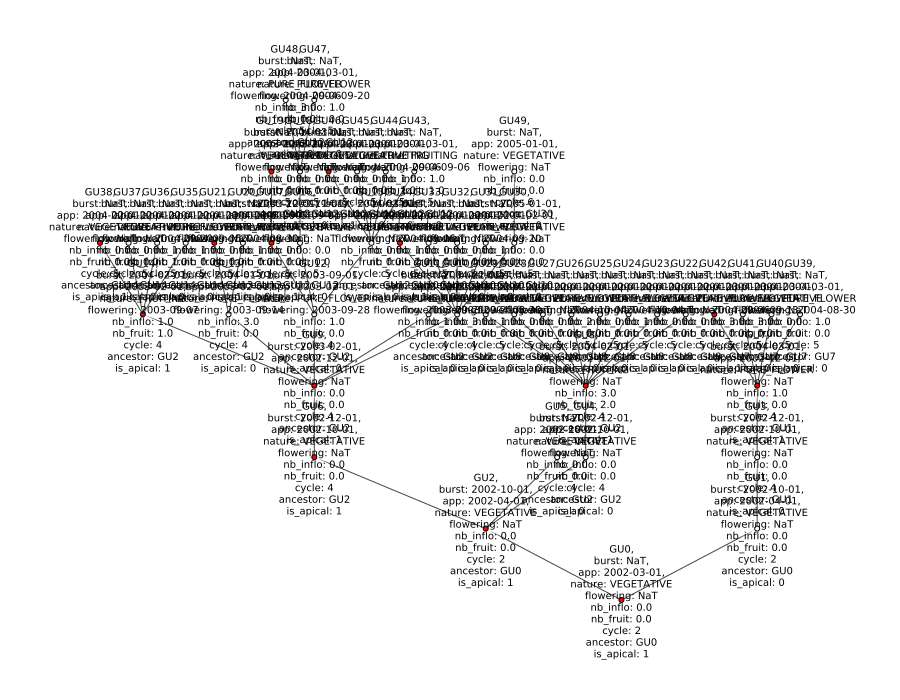

In [9]:
Nature_Names = {v: k for k, v in Nature.items()}
g = ig.Graph.Adjacency([row.tolist() for row in ds_out.topology__adjacency.data.astype(np.int64)])
layout = g.layout_reingold_tilford(root=0.)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(900, 700), margin=(100, 100, 100, 100), **{
    'vertex_size': 5,
    'vertex_label_size': 10,
    'edge_arrow_width': 0.1,
    'vertex_color': ['red' if is_apical else 'white' for is_apical in ds_out.topology__is_apical.data],
    'vertex_label': [
        f'GU{idx}, \
        \nburst: {ds_out.arch_dev__pot_burst_date.data[idx]}, \
        \napp: {ds_out.topology__appearance_date.data[idx].item().isoformat()}, \
        \nnature: {Nature_Names[ds_out.arch_dev__pot_nature.data[idx]]} \
        \nflowering: {ds_out.arch_dev__pot_flowering_date.data[idx]} \
        \nnb_inflo: {ds_out.arch_dev__pot_nb_inflo.data[idx]} \
        \nnb_fruit: {ds_out.arch_dev__pot_nb_fruit.data[idx]} \
        \ncycle: {int(ds_out.topology__cycle.data[idx])} \
        \nancestor: GU{int(ds_out.topology__ancestor.data[idx])} \
        \nis_apical: {int(ds_out.topology__is_apical.data[idx])}' \
        for idx in g.vs.indices
    ]
})